<a href="https://colab.research.google.com/github/ptkoo/ptkoo-Meta-Learning-Bayesian-Optimization/blob/main/Meta_Learning%2C_Bayesian_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  # For data generation and manipulation
import tensorflow as tf  # TensorFlow for building and training models
from tensorflow.keras.optimizers import Adam, SGD  # Adam optimizer for training
from tensorflow.keras import Sequential, layers  # Sequential model and Dense layers
from sklearn.metrics import mean_squared_error  # To calculate RMSE
import keras_tuner as kt  # Keras Tuner for Bayesian optimization
import matplotlib.pyplot as plt  # (Optional) For plotting RMSE if needed
from datetime import datetime
import os

In [ ]:
n_tasks=2
n_train=800
n_test=200
it = 0.0
lt = 4.0
epochs=200
batch_size=32
inner_lr=1.0e-2
epsilon=6.0e-7

In [ ]:
def generate_data():
    x = np.random.uniform(it , lt , n_train)
    x = np.sort(x)
    y = 5 * np.exp(-x) * np.cos(5*x + 1)
    return x, y

def generate_test_data():
    test_x = np.linspace(it , lt, n_test)
    test_y = 5 * np.exp(-test_x) * np.cos(5 * test_x + 1)
    return test_x, test_y

def generate_task_data():
    return [generate_data()[0] for _ in range(n_tasks)], \
           [generate_data()[1] for _ in range(n_tasks)]


In [ ]:
s_x, s_y = generate_task_data()
q_x, q_y = generate_task_data()
test_x, test_y = generate_test_data()

In [ ]:
class hyper_model(kt.HyperModel):
    def __init__(self):
        self.n_tasks = n_tasks
        self.n_train = n_train
        self.n_test = n_test
        self.epochs = epochs
        self.batch_size = batch_size
        self.inner_lr = inner_lr
        self.epsilon = epsilon
        self.s_x, self.s_y = s_x , s_y
        self.q_x, self.q_y = q_x , q_y
        self.test_x, self.test_y = test_x , test_y


    def build(self, hp):
        self.lr_meta = hp.Float('lr_meta', min_value=1e-5, max_value=1e-3, sampling='log')

        model = Sequential([
            layers.Dense(32, activation='relu', input_shape=(1,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(optimizer=SGD(learning_rate=self.lr_meta), loss='mean_squared_error')

        return model

    def create_model_with_hp(self, lr_meta):

        model = Sequential([
            layers.Dense(32, activation='relu', input_shape=(1,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])

        model.compile(optimizer=SGD(learning_rate=lr_meta),
                      loss='mean_squared_error')
        return model

    def fit(self, hp, model, *args, **kwargs):

      #data preparation for support and query
      s_x, s_y = self.s_x, self.s_y
      q_x, q_y = self.q_x, self.q_y

      lr_meta = hp.get('lr_meta')
      loss_fn = tf.keras.losses.MeanSquaredError()
      meta_optimizer = SGD(learning_rate=lr_meta)

      #support model initialization
      support_models = [tf.keras.models.clone_model(model) for _ in range(self.n_tasks)]
      s_xLoss = [None] * self.n_tasks
      historyModel = [None] * self.n_tasks

      for i in range(self.n_tasks):
          if i == 0:
              support_models[i] = model
          else:
              support_models[i] = support_models[i-1]

          support_models[i].compile(
              optimizer=Adam(learning_rate=self.inner_lr),
              loss='mean_squared_error'
          )

          historyModel[i] = support_models[i].fit(
              s_x[i].reshape(-1,1),
              s_y[i],
              epochs=self.epochs,
              batch_size=self.batch_size,
              verbose=0
          )

          s_xLoss[i] = historyModel[i].history['loss'][-1]

      query_models = support_models

      # Meta-update step
      q_x_shuffled, q_y_shuffled, q_datasets = [], [], []

      # Shuffle the input data for each task
      for i in range(self.n_tasks):
          indices = np.arange(len(q_x[i]))
          np.random.shuffle(indices)
          q_x_shuffled.append(q_x[i][indices])
          q_y_shuffled.append(q_y[i][indices])

          # Create TensorFlow datasets
          q_datasets.append(
              tf.data.Dataset.from_tensor_slices(
                  (q_x_shuffled[i], q_y_shuffled[i])
              ).batch(self.batch_size)
          )

      # Zip all datasets together
      zipped_datasets = tf.data.Dataset.zip(tuple(q_datasets))

      # Meta-update training loop
      total_loss = 0
      for batches in zipped_datasets:
          with tf.GradientTape() as tape:
              batch_total_loss = 0

              # Compute predictions and losses for all query tasks
              for i, (q_x_batch, q_y_batch) in enumerate(batches):
                  q_prediction = query_models[i](tf.reshape(q_x_batch, (-1,1)), training=False)
                  q_loss = loss_fn(tf.reshape(q_y_batch, (-1,1)), q_prediction)
                  batch_total_loss += q_loss
                  total_loss += float(q_loss)

          # Evaluate the gradients of the meta_model parameters
          gradients = tape.gradient(batch_total_loss, model.trainable_variables)

          # Update meta_model parameters using the gradients
          meta_optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      # Save final loss
      final_loss = total_loss  # Track total loss
      # Calculate RMSE on test data
      meta_pred = model.predict(self.test_x.reshape(-1, 1), verbose=0)
      rmse = np.sqrt(mean_squared_error(self.test_y, meta_pred))

      print(f"\nTrial results:")
      print(f"Meta learning rate: {lr_meta:.2e}")
      print(f"Support model losses: {[f'{loss:.4f}' for loss in s_xLoss]}")
      print(f"Total loss: {total_loss:.4f}")
      print(f"RMSE: {rmse:.4f}")
      print("----------------------------------------")

      return {'loss': final_loss, 'rmse': rmse}


Trial 3 Complete [00h 02m 16s]
rmse: 0.2952999513802174

Best rmse So Far: 0.2952999513802174
Total elapsed time: 00h 06m 48s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Trial results:
Meta learning rate: 5.28e-04
Support model losses: ['0.0145', '0.0089']
Total loss: 9.1602
RMSE: 0.2637
----------------------------------------

=== Summary of All Iterations ===
Iteration 1: RMSE = 0.270863, lr_meta = 0.000903
Iteration 2: RMSE = 0.294331, lr_meta = 0.000545
Iteration 3: RMSE = 0.292961, lr_meta = 0.000076
Iteration 4: RMSE = 0.266552, lr_meta = 0.000961
Iteration 5: RMSE = 0.263719, lr_meta = 0.000528

Trial results:
Iteration 1:
  Trial 1: RMSE = 0.268550, Loss = 8.673826, lr_meta = 0.000903 (Best trial)
  Trial 2: RMSE = 0.282580, Loss = 8.663619, lr_meta = 0.000867
  Trial 3: RMSE = 0.328647, Loss = 10.650056, lr_meta = 0.000073
Iteration 2:
  Trial 1: RMSE = 0.236001, Loss = 8.563834, lr_meta = 0.000545 (Best trial)
  Trial 2: RMSE = 0.318208, Loss = 11.370785, lr_meta = 0.000040
  Trial 3: RMSE = 0.306651, Loss = 9.281943, lr_meta = 0.000542
Iteration 3:
  Trial 1: RMSE = 0.320319, Loss = 10.532291, lr_meta = 0.000108
  Trial 2: RMSE = 0.325516,

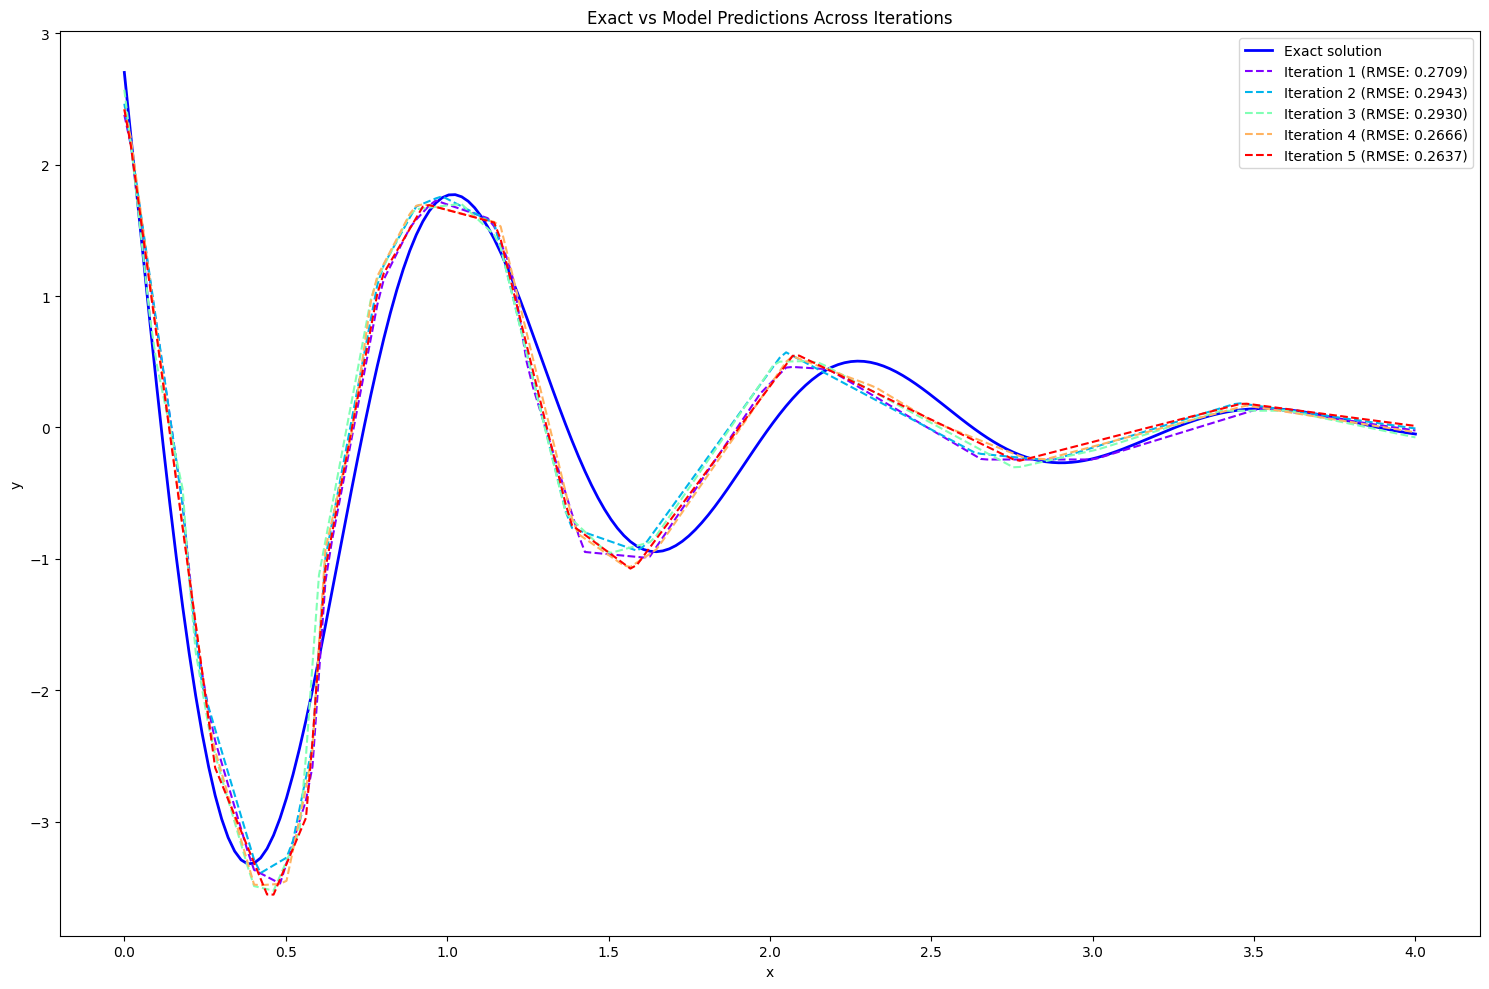

In [ ]:
def run_meta_learning_optimization():
    # Ensure the directory exists
    directory = 'meta_learning_tuning/meta_opt'
    os.makedirs(directory, exist_ok=True)

    objective = kt.Objective("rmse", direction="min")
    start_time = datetime.now()

    # Instantiate the MetaLearningTuner class to access pre-generated data
    final_model = hyper_model()

    s_x, s_y = final_model.s_x, final_model.s_y
    exact_x, exact_y = test_x, test_y

    num_iterations = 5
    max_trials = 3

    all_predictions = []
    all_rmse = []
    all_optimal_lr = []
    trial_results_summary = []

    try:
        for iteration in range(num_iterations):
            print(f"\nIteration {iteration + 1}/{num_iterations}")

            # Start tuning with Bayesian Optimization
            tuner = kt.BayesianOptimization(
                final_model,
                objective=objective,
                max_trials=max_trials,
                num_initial_points=2,
                beta=2.6,
                directory=os.path.join(directory, f'iteration_{iteration}'),
                project_name='meta_opt',
                overwrite=True
            )

            # Perform the search
            tuner.search()

            # Get all trials and their values
            trials = tuner.oracle.trials
            trial_values = []
            for trial_id in sorted(trials.keys()):
                trial = trials[trial_id]
                if trial.status == "COMPLETED":
                    lr_value = trial.hyperparameters.get('lr_meta')
                    rmse = trial.metrics.get_last_value('rmse')
                    loss = trial.metrics.get_last_value('loss')  # Retrieve the loss
                    trial_values.append((lr_value, rmse, loss))  # Include loss in trial results

            # Get optimal hyperparameters and metrics
            best_trial = tuner.oracle.get_best_trials(1)[0]
            optimal_lr_meta = best_trial.hyperparameters.get('lr_meta')
            optimal_rmse = best_trial.metrics.get_last_value('rmse')
            all_optimal_lr.append(optimal_lr_meta)

            # Save trial results for the summary
            trial_results_summary.append((iteration + 1, trial_values, optimal_lr_meta))

            # Build and train the model with best hyperparameters
            optm_hps = tuner.get_best_hyperparameters(1)[0]
            final_best_model = final_model.create_model_with_hp(optimal_lr_meta)
            rmse = final_model.fit(hp=optm_hps, model=final_best_model)

            # Make predictions
            final_pred_y = final_best_model.predict(exact_x.reshape(-1, 1), verbose=0)
            final_rmse = np.sqrt(mean_squared_error(exact_y, final_pred_y))

            # Save model and collect results
            final_model_save_path = os.path.join(directory, f'final_best_model_iteration_{iteration}.keras')
            final_best_model.save(final_model_save_path)
            all_predictions.append(final_pred_y)
            all_rmse.append(final_rmse)

        # Print summary of all iterations
        print("\n=== Summary of All Iterations ===")
        for idx, (rmse_value, lr_value) in enumerate(zip(all_rmse, all_optimal_lr), start=1):
            print(f"Iteration {idx}: RMSE = {rmse_value:.6f}, lr_meta = {lr_value:.6f}")

        # Print detailed trial results with RMSE and loss
        print("\nTrial results:")
        for iteration, trials, best_lr in trial_results_summary:
            print(f"Iteration {iteration}:")
            for trial_idx, (lr_value, rmse, loss) in enumerate(trials, 1):
                if lr_value == best_lr:
                    print(f"  Trial {trial_idx}: RMSE = {rmse:.6f}, Loss = {loss:.6f}, lr_meta = {lr_value:.6f} (Best trial)")
                else:
                    print(f"  Trial {trial_idx}: RMSE = {rmse:.6f}, Loss = {loss:.6f}, lr_meta = {lr_value:.6f}")

        # Record and print total time
        finish_time = datetime.now()
        total_time = finish_time - start_time
        print(f"\nTotal running time: {total_time}")

        # Plot results
        plt.figure(figsize=(15, 10))
        plt.plot(exact_x, exact_y, label='Exact solution', color='blue', linewidth=2)

        colors = plt.cm.rainbow(np.linspace(0, 1, num_iterations))
        for i, (pred_y, rmse, color) in enumerate(zip(all_predictions, all_rmse, colors)):
            plt.plot(exact_x, pred_y, linestyle='--',
                    label=f'Iteration {i+1} (RMSE: {rmse:.4f})', color=color)

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.title("Exact vs Model Predictions Across Iterations")
        plt.tight_layout()
        plt.savefig(os.path.join(directory, 'iterations_comparison.png'))
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    run_meta_learning_optimization()
